# Image to Image Translation using Pix2Pix

In [1]:
import tensorflow as tf
import sys
import time
import os
import random
from keras.optimizers import Adam
from keras.backend import clear_session

2024-05-24 17:44:53.929548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# add folders data_processing and model to path so that we can read in our own modules from this folder
sys.path.append("data_processing")
sys.path.append("model")

# import our own methods 
from load_datasets import load_train_dataset, load_test_dataset
from model_setup import generator, discriminator
from training_methods import train_step  # defined under model/training_methods.py 
from training_methods import pick_image_pair_from_dataset, eval_example_images  # defined under model/training_methods.py 
from visualize_data import plot_image_pair, plot_images_at_epoch  # defined under data_processinig/visualize_data.py 

In [3]:
devices = tf.config.experimental.list_physical_devices("CPU")
print(devices)
#tf.config.experimental.set_memory_growth(devices[0] ,enable=True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
IMAGE_SIZE = 128  # do NOT change

# path to project directory
PROJECT_DIR = "/net/merisi/pbigalke/teaching/METFUT2024/CGAN_Pix2Pix_MSG"

## path to train and val image sets
# DATASET_PATH = f"{PROJECT_DIR}/VIS_IR_images"
TRAIN_PATH = f"{PROJECT_DIR}/VIS_IR_images/train"
TEST_PATH = f"{PROJECT_DIR}/VIS_IR_images/val"

# path where to store output
OUT_PATH = f"{PROJECT_DIR}/output/training_IR_VIS"
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


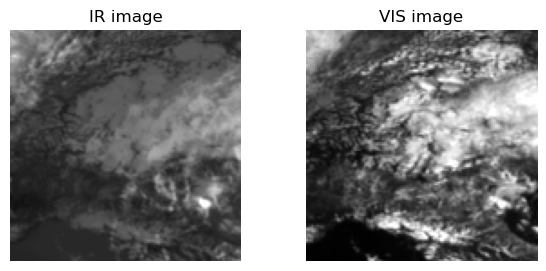

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [5]:
# load and preprocess dataset
BATCH_SIZE = 10

# get all training data
train_dataset = load_train_dataset(TRAIN_PATH, BATCH_SIZE)
print(train_dataset)
ir_img, vis_img = pick_image_pair_from_dataset(train_dataset, BATCH_SIZE)
plot_image_pair(ir_img, vis_img, output_file=None, normalized=True)

# get all test data
test_dataset = load_test_dataset(TEST_PATH, BATCH_SIZE)
print(test_dataset)

In [6]:
clear_session()

# set up generator
gen_model = generator()
gen_model.summary()

# set up discriminator
discr_model = discriminator()
discr_model.summary()

# create optimizers for generator and discriminator
gen_optimizer = Adam(lr=2e-4, beta_1=0.5)
discr_optimizer = Adam(lr=2e-4, beta_1=0.5)


input layer (None, 128, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 64)           1024      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 32, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 16, 16, 256)          525312    ['sequential_1[0][0]']        
                                                              

In [7]:
# define training procedure
def fit(generator, discriminator, gen_optimizer, discr_optimizer, train_dataset, test_dataset, epochs, 
        outpath_img=None, outpath_model=None, save_after_epochs=5):

    start_training = time.time()

    # loop over number of epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        start_epoch = time.time()

        # loop over batches in training dataset
        for n, (input_image, target) in train_dataset.enumerate():
            # perform training step
            gen_loss, disc_loss = train_step(input_image, target, generator, discriminator, 
                                             gen_optimizer, discr_optimizer)
            
        # save example images of this epoch
        if outpath_img is not None:

            # select random image from dataset to evaluate the progess
            ir_img, predict_vis_img, vis_img = eval_example_images(test_dataset, generator, BATCH_SIZE)
            # visualize
            plot_images_at_epoch(ir_img, predict_vis_img, vis_img, 
                                output_file=f"{outpath_img}/example_images_epoch{epoch}.png", 
                                normalized=True)
                
        # save model state
        if epoch % save_after_epochs == 0:
            print("TODO: implement saving of model")

        # calculate the test and print it:
        print("TODO: implement test loss, accuracy etc.")
        
        # print some information on the progress of training
        print("TODO: save losses in an array and return for later plotting")
        print(f"Generator loss: {gen_loss:.2f}, Discriminator loss: {disc_loss:.2f}")
        print(f"Time for epoch {epoch+1}: {(time.time()-start_epoch)/60.:.2f} min.")
        print(f"Total runtime: {(time.time()-start_training)/60.:.2f} min.")


In [8]:
# do the training
epochs = 20
outpath_img = f"{OUT_PATH}/example_images"
if not os.path.exists(outpath_img):
    os.makedirs(outpath_img)
outpath_model = f"{OUT_PATH}/model_states"
if not os.path.exists(outpath_model):
    os.makedirs(outpath_model)


fit(gen_model, discr_model, gen_optimizer, discr_optimizer, train_dataset, test_dataset, epochs, 
    outpath_img=outpath_img, outpath_model=outpath_model)

Epoch 1


2024-05-24 17:45:27.943753: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


TypeError: eval_example_images() got an unexpected keyword argument 'training'